# Siamese Network (Similarity Network)

## Problem Statement
1. How do I train the network to verify faces for Face ID ? (The model mostly wouldn't have seen my face when it was built)
2. How do I train the network to identify signature & verify it ? 
3. How do I retrain the network when I have less number of samples ?

So for we learnt various techniques for Computer Vision and almost all requires tons of labeled data. Less data means the deep learning model will not be able to model different classes properly and will perform poorly. 

## What is Siamese Network
A Siamese network is a class of neural networks that contains one or more identical networks. We feed a pair of inputs to these networks. Each network computes the features of one input. And, then the similarity of features is computed using their difference or the dot product. For same class input pairs, target output is 1 and for different classes input pairs, the output is 0.

![Siamese Network](siamese.png)

By doing this, we have converted the classification problem to a similarity problem. We are training the network to minimize the distance between samples of the same class and increasing the inter-class distance. There are multiple kinds of similarity functions through which the Siamese network can be trained like Contrastive loss, triplet loss, and circle loss.

- Contrastive loss: In Contrastive loss, pairs of images are taken. For same class pairs, distance is less between them. For different pairs, distance is more. 
- Triplet loss: Triplet loss was introduced by Google in 2015 for face recognition. Here, the model takes three inputs- anchor, positive, and negative. The anchor is a reference input. Positive input belongs to the same class as anchor input. Negative input belongs to a random class other than the anchor class.

In [1]:
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, shutil
from random import random, randint, seed
import random
import pickle, itertools, sklearn, pandas as pd, seaborn as sn
from scipy.spatial import distance
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from scipy import spatial
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.layers import Input, Dense, InputLayer, Conv2D, MaxPooling2D
from tensorflow.keras.layers import UpSampling2D, InputLayer, Concatenate, Flatten, Reshape, Lambda, Embedding, dot
from sklearn.model_selection import train_test_split
import os, sys
import tensorflow as tf

In [3]:
# Train autoencoder and save encoder model and encodings
def train_color_encoder(X1, X2, y) :

    # Color Encoder
    input_layer = Input((28, 28, 3))
    layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    layer2 = MaxPooling2D((2, 2), padding='same')(layer1)
    layer3 = Conv2D(8, (3, 3), activation='relu', padding='same')(layer2)
    layer4 = MaxPooling2D((2, 2), padding='same')(layer3)
    layer5 = Flatten()(layer4)
    embeddings = Dense(16, activation=None)(layer5)
    norm_embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

    # Create model
    model = Model(inputs=input_layer, outputs=norm_embeddings)

    # Create siamese model
    input1 = Input((28,28,3))
    input2 = Input((28,28,3))

    # Create left and right twin models
    left_model = model(input1)
    right_model = model(input2)

    # Dot product layer
    dot_product = dot([left_model, right_model], axes=1, normalize=False)

    siamese_model = Model(inputs=[input1, input2], outputs=dot_product)

    # Model summary 
    print(siamese_model.summary())

    # Compile model    
    siamese_model.compile(optimizer='adam', loss= 'mse')
 
    # Plot flowchart fo model
    plot_model(siamese_model, to_file=os.getcwd()+'/siamese_model_mnist.png', show_shapes=1, show_layer_names=1)


    # Fit model
    siamese_model.fit([X1, X2], y, epochs=100, batch_size=5, shuffle=True, verbose=True)

    model.save(os.getcwd()+"/color_encoder.h5")
    siamese_model.save(os.getcwd()+"/color_siamese_model.h5")

    return model, siamese_model

### Prepare positive and negative pais of data samples

In [5]:
# Prepare data for different shapes but same colors

dir = os.getcwd()+"/shapes/"

images = []
y_col = []

for root, dirs, files in os.walk(dir, topdown=False):
    for name in files:
        fullname = os.path.join(root, name)
        if fullname.find(".png") != -1 :
            images.append(fullname)
            if fullname.find("red") != -1 :
                y_col.append(0)
            elif fullname.find("blue") != -1 :
                y_col.append(1)
            else :
                y_col.append(2)

y_col = np.array(y_col)
images = np.array(images)

In [6]:
y_col

array([2, 0, 2, ..., 2, 0, 0])

In [7]:
images

array(['/Users/drs/mycode/pycode/aiml/computer-vision/shapes/triangle/triangle_green41.png',
       '/Users/drs/mycode/pycode/aiml/computer-vision/shapes/triangle/triangle_red335.png',
       '/Users/drs/mycode/pycode/aiml/computer-vision/shapes/triangle/triangle_green187.png',
       ...,
       '/Users/drs/mycode/pycode/aiml/computer-vision/shapes/circle/circle_green98.png',
       '/Users/drs/mycode/pycode/aiml/computer-vision/shapes/circle/circle_red53.png',
       '/Users/drs/mycode/pycode/aiml/computer-vision/shapes/circle/circle_red47.png'],
      dtype='<U85')

In [8]:
red_im = images[np.where(y_col==0)]
green_im = images[np.where(y_col==1)]
blue_im = images[np.where(y_col==2)]

In [9]:
# Test images
test_red_im = red_im[50:]
test_green_im = green_im[50:]
test_blue_im = blue_im[50:]

In [10]:
# Read only 20 images from each class for training
red_im = red_im[:20]
green_im = green_im[:20]
blue_im = blue_im[:20]

In [11]:
positive_red = list(itertools.combinations(red_im, 2))
positive_blue = list(itertools.combinations(blue_im, 2))
positive_green = list(itertools.combinations(green_im, 2))

In [13]:
positive_red[1]

('/Users/drs/mycode/pycode/aiml/computer-vision/shapes/triangle/triangle_red335.png',
 '/Users/drs/mycode/pycode/aiml/computer-vision/shapes/triangle/triangle_red447.png')

In [14]:
len(positive_red)

190

In [15]:
# Generate negative samples
negative1 = itertools.product(red_im,green_im)
negative1 = list(negative1)

negative2 = itertools.product(green_im,blue_im)
negative2 = list(negative2)

negative3 = itertools.product(red_im,blue_im)
negative3 = list(negative3)

In [21]:
negative3[10]

('/Users/drs/mycode/pycode/aiml/computer-vision/shapes/triangle/triangle_red335.png',
 '/Users/drs/mycode/pycode/aiml/computer-vision/shapes/triangle/triangle_green385.png')

In [22]:
# Create pairs of images and set target label for them. Target output is 1 if pair of images have same color else it is 0.
color_X1 = []
color_X2 = []
color_y = []
positive_samples = positive_blue + positive_green + positive_red
negative_samples = negative1 + negative2 + negative3

for fname in positive_samples :
    im = cv2.imread(fname[0])
    color_X1.append(im)
    im = cv2.imread(fname[1])
    color_X2.append(im)
    color_y.append(1)

for fname in negative_samples :
    im = cv2.imread(fname[0])
    color_X1.append(im)
    im = cv2.imread(fname[1])
    color_X2.append(im)
    color_y.append(0)


color_y = np.array(color_y)
color_X1 = np.array(color_X1)
color_X2 = np.array(color_X2)
color_X1 = color_X1.reshape((len(negative_samples) + len(positive_samples), 28, 28, 3))
color_X2 = color_X2.reshape((len(negative_samples) + len(positive_samples), 28, 28, 3))

color_X1 = 1 - color_X1/255
color_X2 = 1 - color_X2/255

print("Color data : ", color_X1.shape, color_X2.shape, color_y.shape)

Color data :  (1770, 28, 28, 3) (1770, 28, 28, 3) (1770,)


In [23]:
color_X1

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [24]:
# Save test data
f = open(os.getcwd()+"/test_images.pkl", 'wb')
pickle.dump([test_red_im, test_blue_im, test_green_im], f)
f.close()

In [25]:
# train model
train_color_encoder(color_X1, color_X2, color_y)

2022-01-22 10:53:41.422044: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 16)           7896        ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dot (Dot)                      (None, 1)            0           ['model[0][0]',            

(<keras.engine.functional.Functional at 0x1401f1f40>,
 <keras.engine.functional.Functional at 0x14024cee0>)

### Test the model

In [26]:
from mpl_toolkits.mplot3d import Axes3D
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, pickle
import sklearn, pandas as pd, seaborn as sn
from keras.models import Model, load_model, Sequential
from keras import backend as K
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [27]:
# Load the saved models
model = load_model(os.getcwd()+"/color_encoder.h5")
siamese_model = load_model(os.getcwd()+"/color_siamese_model.h5")

In [28]:
# Load test data
f = open(os.getcwd()+"/test_images.pkl", 'rb')
test_red_im, test_blue_im, test_green_im = pickle.load(f)
f.close()

In [29]:
# Read files
names = list(test_red_im) + list(test_blue_im) + list(test_green_im)# + list(test_cyan_im) #+ list(test_yellow_im)
names1 = [x for x in names if 'red' in x]
names2 = [x for x in names if 'blue' in x]
names3 = [x for x in names if 'green' in x]

test_im = []
for i in range(len(names)) :
    test_im.append(cv2.imread(names[i]))

r,c,_ = test_im[0].shape
test_im = np.array(test_im)
test_im = test_im.reshape((len(test_im), r,c,3))
names = [x.split("/")[-1] for x in names]

test_im = 1 - test_im/255

In [30]:
test_im[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [31]:
# Predict
pred = model.predict(test_im)

In [33]:
pred[pred > 0.5]

array([0.99818397, 0.99823546, 0.9982997 , ..., 0.9986494 , 0.9989825 ,
       0.9989806 ], dtype=float32)

In [39]:
pred[:,3]

array([-0.05101558, -0.05382137, -0.05249634, ..., -0.01064025,
       -0.01138414, -0.00881887], dtype=float32)

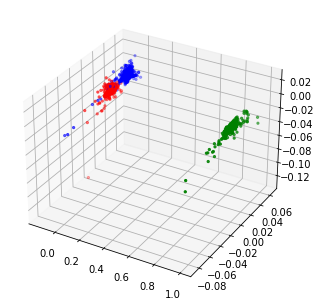

In [40]:
num = int(pred.shape[0]/3)
colors = ['red', 'blue', 'green'] # set colors of target labels

# Set target labels
y = [colors[0] for i in range(num)]
y += [colors[1] for i in range(num)]
y += [colors[2] for i in range(num)]

feat1 = pred[:,0]
feat2 = pred[:,1]
feat3 = pred[:,2]

# Plot 3d scatter plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(feat1, feat2, feat3, c=y, marker='.')
plt.show()

In [41]:
y

['red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',


In [42]:
feat1

array([2.6379791e-04, 4.6973932e-04, 8.1242225e-04, ..., 9.9864942e-01,
       9.9898249e-01, 9.9898058e-01], dtype=float32)

In [43]:
feat2

array([ 0.00654726,  0.00268557,  0.00245514, ..., -0.01174667,
        0.00222349, -0.00617377], dtype=float32)

In [44]:
feat3

array([-0.00189331, -0.00207424, -0.00045072, ...,  0.00029594,
       -0.00298797, -0.00262949], dtype=float32)

## References
1. [https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee](https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee)
2. [https://www.kaggle.com/kmader/image-similarity-with-siamese-networks](https://www.kaggle.com/kmader/image-similarity-with-siamese-networks)
3. [https://medium.com/analytics-vidhya/a-friendly-introduction-to-siamese-networks-283f31bf38cd](https://medium.com/analytics-vidhya/a-friendly-introduction-to-siamese-networks-283f31bf38cd)